#### 使用 FNN 尝试使用用于预测 FHN 模型

`结论说明`
最后的结果表明，虽然最后训练结果的 Loss 值较低，但是在预测时，并不能自主演化，这个原因可能是：前馈神经网络没有内在的机制来处理顺序信息，它将每个输入样本视为独立的，不考虑数据的时间顺序或序列关系。对于时间序列数据，这种处理方式可能会忽略数据中重要的时间依赖特征，导致模型无法准确捕捉数据的动态变化。

接下来，这个预测的尝试将在 RNN 中继续进行

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit, prange

In [19]:
np.random.seed(1)
torch.manual_seed(1)

##### 使用FHN 模型产生数据集

In [20]:
@njit
def Euler(fun, x0, t, dt, *args):
    """
    使用 euler 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程
        x0: 上一个时间单位的状态变量
        t: 运行时间
        dt: 时间步长
    :return: 
        x0 (numpy.ndarray): 下一个时间单位的状态变量
    """
    # 计算下一个时间单位的状态变量
    x0 += dt * fun(x0, t, *args)
    return x0

@njit
def RK4(fun, x0, t, dt, *args):
    """
    使用 Runge-Kutta 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程
        x0: 上一个时间单位的状态变量
        t: 运行时间
        dt: 时间步长
    :return:
        x0 (numpy.ndarray): 下一个时间单位的状态变量
    """
    k1 = fun(x0, t, *args)
    k2 = fun(x0 + (dt / 2.) * k1, t + (dt / 2.), *args)
    k3 = fun(x0 + (dt / 2.) * k2, t + (dt / 2.), *args)
    k4 = fun(x0 + dt * k3, t + dt, *args)

    x0 += (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

    return x0

@njit
def FHN_model(vars, t, I):
    """
        FitzHugh-Nagumo(FHN) 模型
    """
    res = np.zeros_like(vars)
    # 状态变量
    v, w = vars
    # 常数参数
    a, b, c, I_ext = 0.08, 0.8, 0.7, 0.7

    # 模型方程
    dv_dt = v - v**3 / 3 - w + I_ext + I[0]
    dw_dt = a * (v + c - b * w) + I[1]

    # 输出结果
    res[0] = dv_dt
    res[1] = dw_dt

    return res

In [21]:
# 初始化状态变量
N = 1
v0 = np.random.rand(N)
w0 = np.random.rand(N)
vars = np.vstack((v0, w0))
N_vars = 2

dt = 0.01

# 初始化
for i in range(1000_00):
    # 计算下一个时间单位的状态变量
    I=[0.1, 0.]
    RK4(FHN_model, vars, 0, dt, I)

mem = []

for i in range(5000_00):
    # 计算当前时间
    t = i * dt

    # 计算下一个时间单位的状态变量
    I=[0., 0.]
    RK4(FHN_model, vars, t, dt, I)
    
    # 将当前状态变量添加到内存中
    mem.append(vars.copy().flatten())
mem = np.asarray(mem).T

mem_test = []
for i in range(1000_00):
    # 计算当前时间
    t = i * dt

    # 计算下一个时间单位的状态变量
    I=[0.1, 0.]
    RK4(FHN_model, vars, t, dt, I)
    
    # 将当前状态变量添加到内存中
    mem_test.append(vars.copy().flatten())
mem_test = np.asarray(mem_test).T

In [22]:
new_min = -1.  # 新的最小值
new_max = 1.  # 新的最大值
# 处理数据，归一化数据
min1 = np.min(mem[0]) 
max1 = np.max(mem[0])

min2 = np.min(mem[1])
max2 = np.max(mem[1])

mem[0] = (mem[0] - min1) / (max1 - min1) * (new_max - new_min) + new_min
mem[1] = (mem[1] - min2) / (max2 - min2) * (new_max - new_min) + new_min
mem_test[0] = (mem_test[0] - min1) / (max1 - min1) * (new_max - new_min) + new_min
mem_test[1] = (mem_test[1] - min2) / (max2 - min2) * (new_max - new_min) + new_min

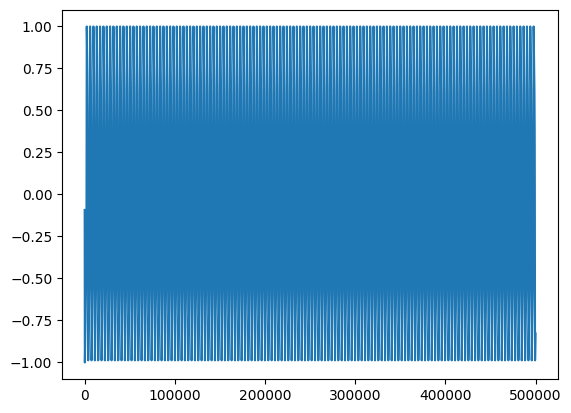

In [23]:
plt.plot(mem[0])
plt.show()

In [24]:
# 选择设备
# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
# 构建神经网络
class Predicter(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, lr):
        super().__init__()
        # 定义网络结构
        self.model = nn.Sequential(
            nn.Linear(N_input, N_hidden[0]), # 输入层到隐藏层
            nn.LeakyReLU(), # 激活函数
            nn.Linear(N_hidden[0], N_hidden[1]), # 隐藏层1到隐藏层2
            nn.LeakyReLU(), # 激活函数
            nn.Linear(N_hidden[1], N_output), # 隐藏层2到输出层
            # nn.Sigmoid() # 激活函数
        ).type(dtype).to(device)

        # 定义损失函数
        self.loss_fun = nn.MSELoss()

        # 定义优化器
        # self.optimiser = torch.optim.SGD(self.parameters(), lr=lr)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=lr)

        # 定义历史损失
        self.counter = 0    # 训练次数
        self.history = []

    def forward(self, x):
        # 前向传播
        x = self.model(x)
        return x
    
    def NN_train(self, inputs_list, targets_list):
        '''
            训练网络分为两步：
            1、给定训练样本计算输出
            2、将计算得到的输出与设置的标准输出做对比，得到误差函数指导网络权重更新
        '''
        # 前向传播
        outputs = self.model(inputs_list)

        # 计算损失函数
        loss = self.loss_fun(outputs, targets_list)

        # 清空梯度
        self.optimiser.zero_grad()

        # 反向传播
        loss.backward()

        # 更新参数
        self.optimiser.step()

        # 记录损失函数
        self.counter += 1
        if self.counter%100==0:
            self.history.append(loss.item())

In [26]:
# 给定输入层，隐藏层，输出层的节点数量
input_nodes = 2
output_nodes = 2

hidden_nodes = (200, 200)

# 给定学习率
learning_rate = 0.001

In [27]:
FNN = Predicter(input_nodes, output_nodes, hidden_nodes, learning_rate)

In [28]:
memData = mem.T
memData.shape

(500000, 2)

In [29]:
print("======= 开始训练 =======")

for i in range(memData.shape[0]-1):

    if i%10_00==0:    
        print("\r", "学习进度：{:.3f} %".format(i*100/memData.shape[0]), end='', flush=True)

    # 将数据转换为 tensor
    inputs = torch.tensor(memData[i]).type(dtype).to(device)
    targets = torch.tensor(memData[i+1]).type(dtype).to(device)

    # 训练网络
    FNN.NN_train(inputs, targets)

print("\n======= 训练完成 =======\n")

======= 开始训练 =======
 学习进度：99.800 %
======= 训练完成 =======



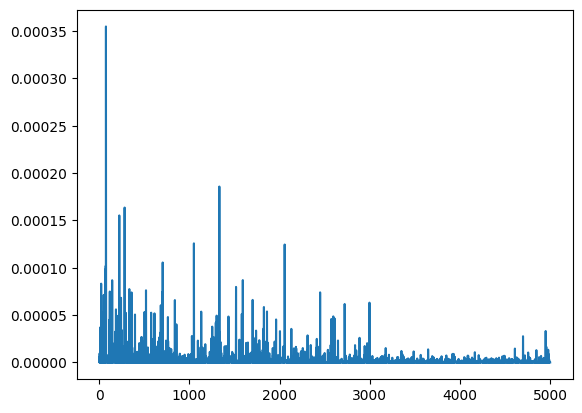

In [30]:
history = FNN.history
plt.plot(history)
plt.show()

In [31]:
memTest = mem_test.T
memTest.shape

(100000, 2)

In [32]:
mem_list = []
FNN.eval() # 设置为评估模式
mem_init = torch.tensor(memTest[0]).type(dtype).to(device)
with torch.no_grad():  # 测试时不需要计算梯度
    for i in range(memTest.shape[0]-1):

        if i%10_00==0:    
            print("\r", "进度：{:.3f} %".format(i*100/memTest.shape[0]), end='', flush=True)

        # 测试数据
        mem_init = FNN(mem_init)
        
        mem_list.append(mem_init.cpu().detach().numpy().flatten())

 进度：99.000 %

In [33]:
mem_list = np.asarray(mem_list).T

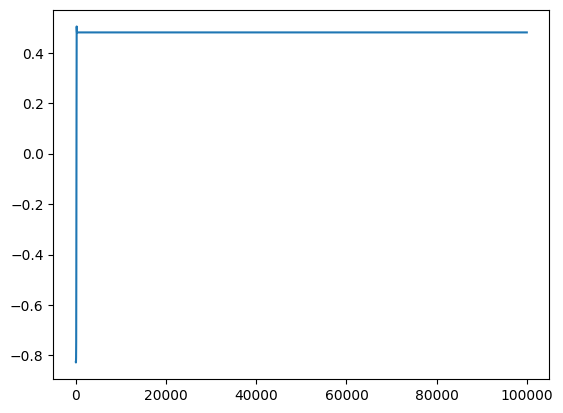

In [34]:
plt.plot(mem_list[0], label='预测值')
# plt.xlim(-10, 1000)
plt.show()